In [4]:
import os
import cv2
import glob
import numpy as np
import pandas as pd
import mediapipe as mp
from pathlib import Path

## 동영상을 프레임 이미지로 변환

In [5]:
EVENT_FRAME_COL = "frame_idx"
EVENT_TIME_COL  = "time_sec"
EVENT_FLAG_COL  = "flag_id" 

In [ ]:
def estimate_fps_from_events(csv_path: str) -> float:
    """
    이벤트 플래그 CSV에서 (frame_idx / time_sec) 평균으로 실제 FPS 추정.
    """
    df = pd.read_csv(csv_path)
    df = df.dropna(subset=[EVENT_FRAME_COL, EVENT_TIME_COL])
    
    # 0초인 경우(시작 이벤트 등)는 제외
    df = df[df[EVENT_TIME_COL] > 0]

    fps_list = df[EVENT_FRAME_COL] / df[EVENT_TIME_COL]
    fps_est = fps_list.mean()
    print(f"[FPS] {csv_path.name} → {fps_est:.3f}")
    return float(fps_est)


In [ ]:
def video_to_frames(video_path: str, out_dir: str, image_ext: str = ".jpg") -> int:
    """
    mp4 영상을 프레임 단위 이미지로 저장.
    return: 저장된 프레임 수
    """
    os.makedirs(out_dir, exist_ok=True)
    
    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        raise RuntimeError(f"Failed to open video: {video_path}")
    
    count = 0
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        
        fname = f"frame_{count:06d}{image_ext}"
        fpath = os.path.join(out_dir, fname)
        cv2.imwrite(fpath, frame)
        count += 1
    
    cap.release()
    print(f"[video_to_frames] {video_path} -> {count} frames saved at {out_dir}")
    return count


In [ ]:
def convert_videos_with_custom_index(
        video_dir: str, 
        output_root: str,
        case_name: str,
        start_index: int,
        end_index: int):
    """
    video_dir 안의 mp4 파일을 순서대로 읽고,
    출력 폴더 번호는 start_index ~ end_index 로 직접 지정.

    예: start=1, end=36 → normal_001, normal_002 ... normal_036 생성
    """

    video_files = sorted(glob.glob(os.path.join(video_dir, "*.mp4")))

    total_required = end_index - start_index + 1
    if total_required != len(video_files):
        print(f"[경고] mp4 파일 수({len(video_files)})와 지정한 출력 개수({total_required})가 다름")
        print("파일 수에 맞춰 번호를 지정하거나, 번호 범위를 조정하세요.")
    
    for i, vpath in enumerate(video_files):
        out_num = start_index + i
        out_folder = f"{case_name}_{out_num:03d}"
        out_dir = os.path.join(output_root, out_folder)

        print(f"▶ 변환 시작: {os.path.basename(vpath)} → {out_dir}")

        video_to_frames(video_path=vpath, out_dir=out_dir)

In [ ]:
def fps_list(folder_path: str) -> list:
    """
    폴더 안의 모든 *_events.csv 파일을 찾아 FPS 추정 후 리스트로 반환.
    """
    folder = Path(folder_path)
    csv_files = sorted(folder.glob("*_events.csv"))

    if not csv_files:
        print("[WARN] No *_events.csv files found.")
        return []

    fps_results = []

    for csv_file in csv_files:
        fps = estimate_fps_from_events(csv_file)
        fps_results.append({
            "file": csv_file.name,
            "fps": fps
        })

    return fps_results

## 이벤트 플레그 변환
-   학습용으로 사용할 수 있도록 array 형태의 데이터로 변환

In [6]:
KEY_TO_ACTION = {
    "A": 0,  # 작업 A
    "S": 1,  # 작업 B
    "D": 2,  # 작업 C
}
NUM_ACTIONS = 3
EVENT_FRAME_COL = "frame_idx"
EVENT_KEY_COL   = "flag_key"

In [8]:
# --------------------------------------------------------
# 1) 이벤트 CSV → 0/1 interval label 변환
# --------------------------------------------------------
def build_interval_labels(n_frames: int, csv_path: str) -> np.ndarray:
    """
    이벤트 csv를 읽어 A/S/D의 'active' 구간을 프레임별 0/1 라벨로 변환.
    - 토글 방식: 같은 키가 다시 들어오면 0→1, 1→0 으로 반전.
    return: (n_frames, NUM_ACTIONS) 배열
    """
    labels = np.zeros((n_frames, NUM_ACTIONS), dtype=np.float32)
    df = pd.read_csv(csv_path)
    df = df.sort_values(EVENT_FRAME_COL)

    state = np.zeros(NUM_ACTIONS, dtype=np.int8)
    last_frame = 0

    for _, row in df.iterrows():
        fidx = int(row[EVENT_FRAME_COL])
        key  = str(row[EVENT_KEY_COL]).strip().upper()

        if key not in KEY_TO_ACTION:
            continue

        act_idx = KEY_TO_ACTION[key]

        # last_frame ~ fidx-1 구간
        if fidx > n_frames:
            fidx = n_frames

        labels[last_frame:fidx, :] = state

        # 토글
        state[act_idx] = 1 - state[act_idx]
        last_frame = fidx

        if last_frame >= n_frames:
            break

    # 마지막 이후
    if last_frame < n_frames:
        labels[last_frame:, :] = state

    return labels

In [11]:
# --------------------------------------------------------
# 2) CSV 내용 확인
# --------------------------------------------------------
def inspect_event_csv(csv_path: str):
    df = pd.read_csv(csv_path)
    keys = {str(k).strip().upper() for k in df[EVENT_KEY_COL].dropna().unique()}
    print(f"[inspect_event_csv] {os.path.basename(csv_path)}")
    print("  - unique keys:", sorted(keys))

    unknown = [k for k in keys if k not in KEY_TO_ACTION]
    if unknown:
        print("  - [WARN] undefined keys:", unknown)
    else:
        print("  - all keys valid.")

In [9]:
# --------------------------------------------------------
# 3) 라벨 검증
# --------------------------------------------------------
def verify_labels(interval_labels: np.ndarray, csv_path: str):
    df = pd.read_csv(csv_path)
    keys = {str(k).strip().upper() for k in df[EVENT_KEY_COL].dropna().unique()}
    used_actions = {KEY_TO_ACTION[k] for k in keys if k in KEY_TO_ACTION}

    issues = []

    # CSV 없음 & 라벨 1 있음
    for key, idx in KEY_TO_ACTION.items():
        if idx not in used_actions:
            if interval_labels[:, idx].max() > 0.5:
                issues.append(
                    f"[verify_labels] '{key}' appears in labels but never appears in CSV."
                )

    # CSV 있음 & 라벨이 전부 0임
    for key, idx in KEY_TO_ACTION.items():
        if idx in used_actions:
            if interval_labels[:, idx].max() == 0:
                issues.append(
                    f"[verify_labels] '{key}' appears in CSV but label column is all 0."
                )

    # 정의되지 않은 키 검사
    unknown = [k for k in keys if k not in KEY_TO_ACTION]
    if unknown:
        issues.append(f"[verify_labels] undefined keys in CSV: {unknown}")

    return issues

In [10]:
# --------------------------------------------------------
# 4) CSV 폴더 기반 자동 처리 루프
# --------------------------------------------------------
def generate_labels_from_csv_dir(csv_dir: str, out_dir: str, default_frames: int = None):
    """
    csv_dir 아래에서 '*_events.csv'를 모두 찾아 라벨 CSV 생성.
    n_frames은 다음 중 하나로 결정:
      - default_frames가 제공되면 그 값을 사용
      - 아니면 CSV 내부의 최대 frame_idx + 1 자동 계산
    """
    os.makedirs(out_dir, exist_ok=True)

    csv_files = glob.glob(os.path.join(csv_dir, "*_events.csv"))
    if not csv_files:
        print("[ERROR] No *_events.csv found in:", csv_dir)
        return

    for csv_path in sorted(csv_files):
        fname = os.path.basename(csv_path)  # 예: video_normal_001_events.csv
        sample_name = fname.replace("_events.csv", "")
        print(f"\n[PROCESS] {sample_name}")

        # CSV 내용체크
        inspect_event_csv(csv_path)

        # 프레임 수 계산
        df = pd.read_csv(csv_path)
        if default_frames is not None:
            n_frames = int(default_frames)
            print(f"[INFO] Using default n_frames={n_frames}")
        else:
            max_frame = int(df[EVENT_FRAME_COL].max())
            n_frames = max_frame + 30  # 버퍼 여유(필요시 조정)
            print(f"[INFO] Inferred n_frames={n_frames} from CSV max frame {max_frame}")

        # 라벨 생성
        interval_labels = build_interval_labels(n_frames, csv_path)
        print(f"[INFO] labels shape = {interval_labels.shape}")

        # 검증
        issues = verify_labels(interval_labels, csv_path)
        if issues:
            print(f"[WARN] issues in {sample_name}:")
            for i in issues:
                print("   -", i)
        else:
            print("[OK] label verification passed")

        # 저장
        out_csv = os.path.join(out_dir, f"{sample_name}_lange.csv")
        pd.DataFrame(interval_labels, columns=["A", "S", "D"]).to_csv(out_csv, index=False)

        print(f"[SAVE] {out_csv}")

In [15]:
csv_dir = r"test_data\test_flagle"   # test 이벤트 CSV만 모아놓은 폴더
out_dir = r"test_data\test_csv"

generate_labels_from_csv_dir(csv_dir, out_dir)


[PROCESS] video_ idle_001
[inspect_event_csv] video_ idle_001_events.csv
  - unique keys: ['END', 'START']
  - [WARN] undefined keys: ['END', 'START']
[INFO] Inferred n_frames=284 from CSV max frame 254
[INFO] labels shape = (284, 3)
[WARN] issues in video_ idle_001:
   - [verify_labels] undefined keys in CSV: ['END', 'START']
[SAVE] test_data\test_csv\video_ idle_001_lange.csv

[PROCESS] video_missing1_new_001
[inspect_event_csv] video_missing1_new_001_events.csv
  - unique keys: ['D', 'END', 'S', 'START']
  - [WARN] undefined keys: ['END', 'START']
[INFO] Inferred n_frames=216 from CSV max frame 186
[INFO] labels shape = (216, 3)
[WARN] issues in video_missing1_new_001:
   - [verify_labels] undefined keys in CSV: ['END', 'START']
[SAVE] test_data\test_csv\video_missing1_new_001_lange.csv

[PROCESS] video_missing1_new_002
[inspect_event_csv] video_missing1_new_002_events.csv
  - unique keys: ['A', 'D', 'END', 'START']
  - [WARN] undefined keys: ['END', 'START']
[INFO] Inferred n_fram

## 랜드마크 추출

In [2]:
# 비디오가 있는 폴더 경로
# 상대경로 사용하면 좀 더 깔끔해요
root_dir = "data\idle" 

<>:3: SyntaxWarning: invalid escape sequence '\i'
<>:3: SyntaxWarning: invalid escape sequence '\i'
C:\Users\user\AppData\Local\Temp\ipykernel_23452\2584232742.py:3: SyntaxWarning: invalid escape sequence '\i'
  root_dir = "data\idle"


In [3]:
# 파일 리스트 만들어주는 함수
def find_frame_dirs(root_dir):
    frame_dirs = []
    for dirpath, dirnames, filenames in os.walk(root_dir):
        if any(f.lower().endswith((".jpg", ".png")) for f in filenames):
            frame_dirs.append(dirpath)
    return sorted(frame_dirs)

In [4]:
# mediapipe사용하여 핸드 렌드마크 npz 생성
mp_hands = mp.solutions.hands

def extract_hands_for_folder(frames_dir: str, out_npz_path: str,
                             max_hands: int = 2):
    """
    frames_dir 안의 frame_*.jpg에 대해 MediaPipe Hands 수행.
    각 프레임마다 (max_hands, 21, 3) 랜드마크를 담아서 (N, max_hands*21*3) 배열로 저장.
    """
    frame_files = sorted([
        f for f in os.listdir(frames_dir)
        if f.lower().endswith((".jpg", ".png"))
    ])
    if not frame_files:
        print(f"[WARN] no images in {frames_dir}")
        return
    
    hands = mp_hands.Hands(
        static_image_mode=True,
        max_num_hands=max_hands,
        min_detection_confidence=0.5
    )

    all_kps = []

    for fname in frame_files:
        img_path = os.path.join(frames_dir, fname)
        img_bgr = cv2.imread(img_path)
        if img_bgr is None:
            print(f"[WARN] failed to read {img_path}")
            continue
        img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

        result = hands.process(img_rgb)

        # 기본 0으로 초기화: (max_hands, 21, 3)
        feat = np.zeros((max_hands, 21, 3), dtype=np.float32)

        if result.multi_hand_landmarks:
            for hi, hand_lms in enumerate(result.multi_hand_landmarks[:max_hands]):
                for li, lm in enumerate(hand_lms.landmark):
                    feat[hi, li, 0] = lm.x   # 0~1 정규화 좌표
                    feat[hi, li, 1] = lm.y
                    feat[hi, li, 2] = lm.z

        all_kps.append(feat.reshape(-1))  # (max_hands*21*3,)

    hands.close()

    all_kps = np.stack(all_kps, axis=0)  # (N, max_hands*21*3)
    os.makedirs(os.path.dirname(out_npz_path), exist_ok=True)
    np.savez_compressed(out_npz_path, hand_kps=all_kps)

    print(f"[extract_hands_for_folder] {frames_dir} -> {out_npz_path}, shape={all_kps.shape}")

In [5]:
# 폴더 경로설정 확인용
'''text
프레임 폴더들:
   out_video\video_normal_001
   out_video\video_normal_002
   ...
'''
# 이런식으로 어떤 폴더가 있는지 나와야 해요
frame_dirs = find_frame_dirs(root_dir)
print("프레임 폴더들:")
for d in frame_dirs:
    print("  ", d)

프레임 폴더들:
   data\idle\video_idle_001
   data\idle\video_idle_002
   data\idle\video_idle_003
   data\idle\video_idle_004
   data\idle\video_idle_005
   data\idle\video_idle_006
   data\idle\video_idle_007
   data\idle\video_idle_008
   data\idle\video_idle_009
   data\idle\video_idle_010
   data\idle\video_idle_011
   data\idle\video_idle_012
   data\idle\video_idle_013
   data\idle\video_idle_014
   data\idle\video_idle_015
   data\idle\video_idle_016
   data\idle\video_idle_017
   data\idle\video_idle_018
   data\idle\video_idle_019
   data\idle\video_idle_020
   data\idle\video_idle_021
   data\idle\video_idle_022
   data\idle\video_idle_023
   data\idle\video_idle_024
   data\idle\video_idle_025
   data\idle\video_idle_026
   data\idle\video_idle_027
   data\idle\video_idle_028
   data\idle\video_idle_029
   data\idle\video_idle_030
   data\idle\video_idle_031
   data\idle\video_idle_032
   data\idle\video_idle_033
   data\idle\video_idle_034
   data\idle\video_idle_035
   data\idl

In [7]:
# "out_npz"는 npz를 담을 폴더 이름 또는 경로
hands_out_root = os.path.join(root_dir, r"idle/out_npz")
os.makedirs(hands_out_root, exist_ok=True)

for frames_dir in frame_dirs:
    sample_name = os.path.basename(frames_dir)  # 예: video_normal_001
    out_npz_path = os.path.join(hands_out_root, f"hands_{sample_name}.npz")
    extract_hands_for_folder(frames_dir, out_npz_path)

[extract_hands_for_folder] data\idle\video_idle_001 -> data\idle\idle/out_npz\hands_video_idle_001.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_002 -> data\idle\idle/out_npz\hands_video_idle_002.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_003 -> data\idle\idle/out_npz\hands_video_idle_003.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_004 -> data\idle\idle/out_npz\hands_video_idle_004.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_005 -> data\idle\idle/out_npz\hands_video_idle_005.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_006 -> data\idle\idle/out_npz\hands_video_idle_006.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_007 -> data\idle\idle/out_npz\hands_video_idle_007.npz, shape=(240, 126)
[extract_hands_for_folder] data\idle\video_idle_008 -> data\idle\idle/out_npz\hands_video_idle_008.npz, shape=(240, 126)
[extract_hands_for_folder] data\

## 시각화

In [12]:
import numpy as np
import os
import cv2
import matplotlib.pyplot as plt

# paths
frames_dir = r"data\idle\video_idle_010"                     # 프레임 이미지 폴더
npz_path    = r"data\idle\idle\out_npz\hands_video_idle_010.npz"                # 생성된 npz 파일

# load data
data      = np.load(npz_path)
hand_kps  = data["hand_kps"]   # shape = (N, 126)

print("hand_kps shape:", hand_kps.shape)


hand_kps shape: (240, 126)


In [9]:
def decode_hand_kps(flat):
    """
    flat: (126,) = 2 * 21 * 3
    return: (2, 21, 3)
    """
    if len(flat) != 126:
        raise ValueError("손 랜드마크 길이가 126이 아닙니다. MediaPipe Hands 기준 다시 확인 필요.")
    return flat.reshape(2, 21, 3)


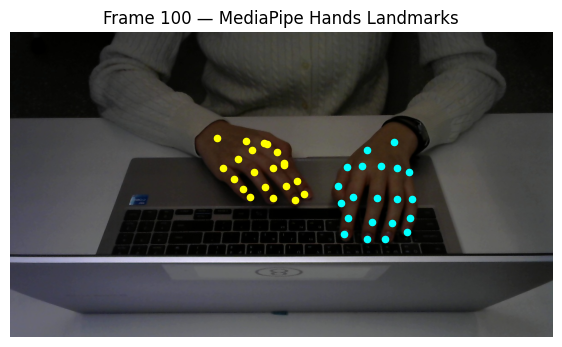

In [13]:
idx = 100   # 원하는 프레임 index로 변경

frame_files = sorted([
    f for f in os.listdir(frames_dir)
    if f.lower().endswith((".jpg", ".png"))
])

# 이미지 로드
img_path = os.path.join(frames_dir, frame_files[idx])
img_bgr = cv2.imread(img_path)
img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

# 랜드마크 복원
kp = decode_hand_kps(hand_kps[idx])  # (2, 21, 3)

h, w, _ = img.shape

plt.figure(figsize=(7,7))
plt.imshow(img)
ax = plt.gca()

# 손이 2개까지 있으므로 loop
colors = ["yellow", "cyan"]  # 왼손/오른손 구분 색
for hand_id in range(2):
    for i in range(21):
        x = kp[hand_id, i, 0] * w
        y = kp[hand_id, i, 1] * h

        # 0이 들어간 프레임은 손 없음 → 랜드마크 점 안 찍기
        if kp[hand_id, i, 0] == 0 and kp[hand_id, i, 1] == 0:
            continue

        ax.scatter(x, y, s=20, color=colors[hand_id])

plt.title(f"Frame {idx} — MediaPipe Hands Landmarks")
plt.axis("off")
plt.show()


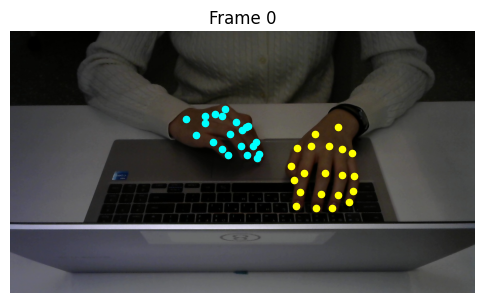

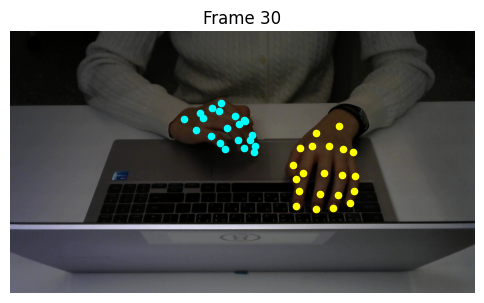

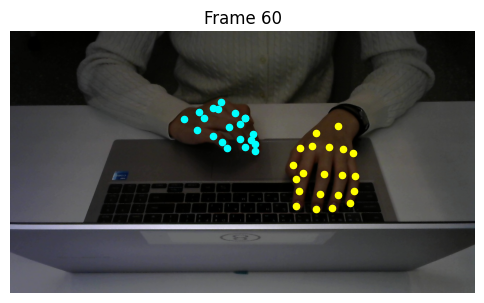

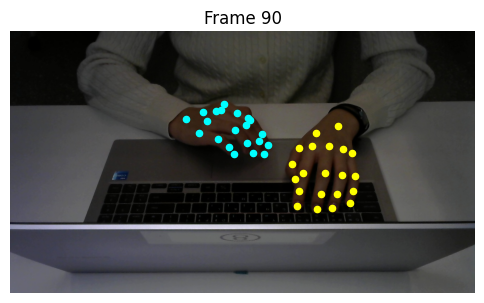

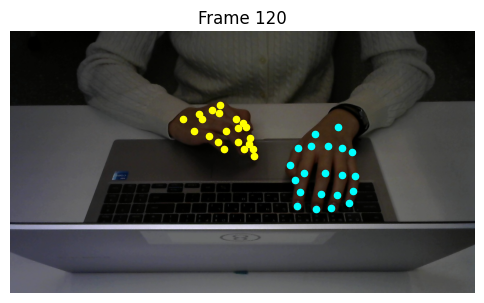

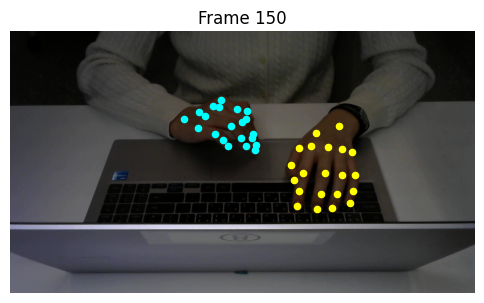

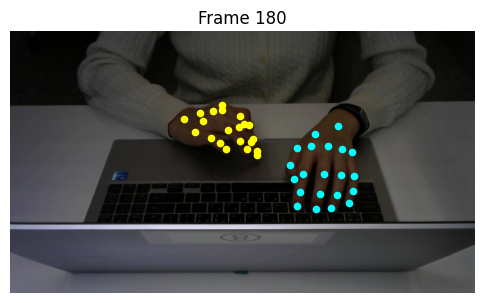

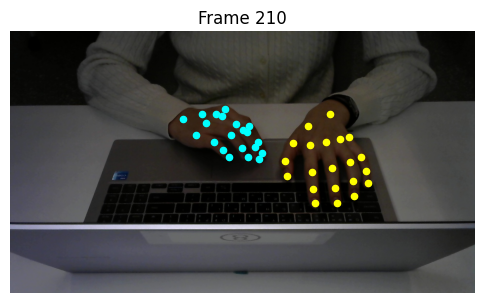

In [14]:
sample_step = 30   # 30프레임마다 확인

for idx in range(0, len(hand_kps), sample_step):
    img_path = os.path.join(frames_dir, frame_files[idx])
    img_bgr = cv2.imread(img_path)
    img = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)

    kp = decode_hand_kps(hand_kps[idx])

    plt.figure(figsize=(6,6))
    plt.imshow(img)
    ax = plt.gca()

    colors = ["yellow", "cyan"]
    for hand_id in range(2):
        for i in range(21):
            x = kp[hand_id, i, 0] * img.shape[1]
            y = kp[hand_id, i, 1] * img.shape[0]

            if kp[hand_id, i, 0] == 0 and kp[hand_id, i, 1] == 0:
                continue

            ax.scatter(x, y, s=20, color=colors[hand_id])

    plt.title(f"Frame {idx}")
    plt.axis("off")
    plt.show()
